# OpenLandMap USDA Soil Taxonomy Great Groups
- https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_GRTGROUP_USDA-SOILTAX_C_v01#bands
- https://zenodo.org/record/3528062
> Distribution of the USDA soil great groups based on machine learning predictions from global compilation of soil profiles (>350,000 training points)

In [1]:
# File and Data Manipulation
import os                       # interacting with the operating system
import glob                     # retrieving files/pathnames matching a specified pattern
from collections import Counter # counting hashable objects
import shutil                   # high-level file operations
import pickle                   # serializing and de-serializing Python object structures

# File and Temporary Data Management
import tempfile  # for creating temporary files and directories

# Data Analysis
import numpy as np              # numerical operations
import pandas as pd             # data manipulation and analysis

# Geospatial Data Handling
import geopandas as gpd         # working with geospatial data

# Data Visualization
import matplotlib.pyplot as plt       # creating static, interactive, and animated visualizations
plt.style.use("default")              # Set the default style matplotlib plots
import matplotlib.colors as mcolors   # colors for legend
import matplotlib.patches as mpatches # drawing patches (shapes) for legend
from matplotlib.ticker import MaxNLocator     # control the maximum number of ticks on plots
from matplotlib.ticker import MultipleLocator # control tick intervals on plots
import matplotlib.ticker as mticker           # advanced tick formatting and placement
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # inset for colorbar

# Raster Operations
import rasterio                       # core library
from rasterio.plot import show        # for displaying raster images

# Data Transformation and Resampling
from rasterio.enums import Resampling # different resampling algorithms
from rasterio.warp import calculate_default_transform # transformation calculation for reprojecting
from rasterio.warp import reproject   # for reprojecting raster data

# Geospatial Analysis and Masking
from rasterio.mask import mask              # masking raster data based on shapes
from rasterio.features import geometry_mask # creating masks from geometric shapes

# Advanced Raster Operations
from rasterio.merge import merge          # merging multiple raster datasets
from rasterio.plot import plotting_extent # plotting extent for matplotlib alignment
from rasterio.crs import CRS              # handling Coordinate Reference Systems

# Memory Handling and I/O Operations
from rasterio.io import MemoryFile        # in-memory raster data operations

# Suppress Warnings
import warnings                   # handling warnings
warnings.filterwarnings("ignore") # Suppress all warnings (use with caution!)

#Clip Raster to a Shapefile
def clip_raster_by_geometry(raster_path, geometry, output_path):
    """
    Clip a raster based on given geometry.

    Parameters:
    - raster_path (str): Path to the input raster file.
    - geometry (geopandas.GeoSeries or GeoDataFrame): The geometry to clip with.
    - output_path (str): Path to the output clipped raster file.
    """
    
    # Check if the output file already exists
    if os.path.exists(output_path):
        print(f"The file {output_path} already exists!")
        return
    
    with rasterio.open(raster_path) as src:
        clipped, transform = mask(src, geometry, crop=True)
        clipped_meta = src.meta.copy()  # Get metadata of the original raster
        clipped_meta.update({
            "driver": "GTiff", 
            "height": clipped.shape[1], 
            "width": clipped.shape[2], 
            "transform": transform
        })

        with rasterio.open(output_path, "w", **clipped_meta) as dest:
            dest.write(clipped)
            
# Reproject Data for Area Calculatons# Reproject Data for Area Calculatons
def reproject_raster(input_raster, output_raster, new_crs):
    """Reproject a raster to a new coordinate reference system."""

    # Check if the output file already exists
    if os.path.exists(output_raster):
        print(f"Output raster {output_raster} already exists!")
        return

    with rasterio.open(input_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, new_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': new_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=new_crs,
                    resampling=Resampling.bilinear
                )
    print(f"Raster reprojected to {new_crs} and saved as {output_raster}.")

In [2]:
# Define Working Directory
os.chdir('J:\Chomiak_Python\Chomiak_Notebooks\Maps_Siberia_Data')

# Yenisey Watershed (Shapefile)
AGRO_Watershed = gpd.read_file('ArcticGRO_Yenisei_watershed')
# Lakes (Shapefile)
gpd_lakes = gpd.read_file('GeoPandas_Yenisei_lakes')

# Open watershed boundary dictionary
with open('watersheds_gdfs.pkl', 'rb') as file:
    watersheds_gdfs = pickle.load(file)
print("Dictionary loaded successfully.")

# Nizhnyaya Tunguska Confluence
nt_confluence = watersheds_gdfs['w_3221']

# Clip Shapefile to the Area of Interest
ntc_lakes = gpd.clip(nt_confluence, gpd_lakes)

Dictionary loaded successfully.


In [3]:
# Table
asd = pd.read_csv('Yenisey_2016_USDA_Soil_Taxonomy_Table_final.csv')

# Raster File
soil_raster = 'Yenisey_2016_USDA_Soil_Taxonomy.tif'
with rasterio.open(soil_raster) as src:
    meta = src.meta
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 13758,
 'height': 11245,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.002245788210298804, 0.0, 83.98574170054437,
        0.0, -0.002245788210298804, 71.62716917927006)}

In [4]:
# Change CRS and Calculate the total area in km2
AGRO_Watershed_3573 = AGRO_Watershed.to_crs(3573)
nt_confluence_3573 = nt_confluence.to_crs(3573)
yenisey_3573_area_km2 = AGRO_Watershed_3573.geometry.area.sum() / 1e6
nt_confluence_3573_area_km2 = nt_confluence_3573.geometry.area.sum() / 1e6
ac_coverage = (nt_confluence_3573_area_km2 / yenisey_3573_area_km2)*100
print(f"Yenisey = {yenisey_3573_area_km2:.0f} km2")
print(f"nt Confluence = {nt_confluence_3573_area_km2:.0f} km2")
print(f"Soil Raster Coverag = {ac_coverage:.1f} %")

Yenisey = 2577444 km2
nt Confluence = 158402 km2
Soil Raster Coverag = 6.1 %


In [5]:
# Clip Raster to the Yenisey River Basin Watershed (EPSG:4326)
soil_in = 'Yenisey_2016_USDA_Soil_Taxonomy.tif'
soil_out = "Soil_nt_confluence.tif"
geometry = nt_confluence.geometry
clip_raster_by_geometry(soil_in, geometry, soil_out)

The file Soil_nt_confluence.tif already exists!


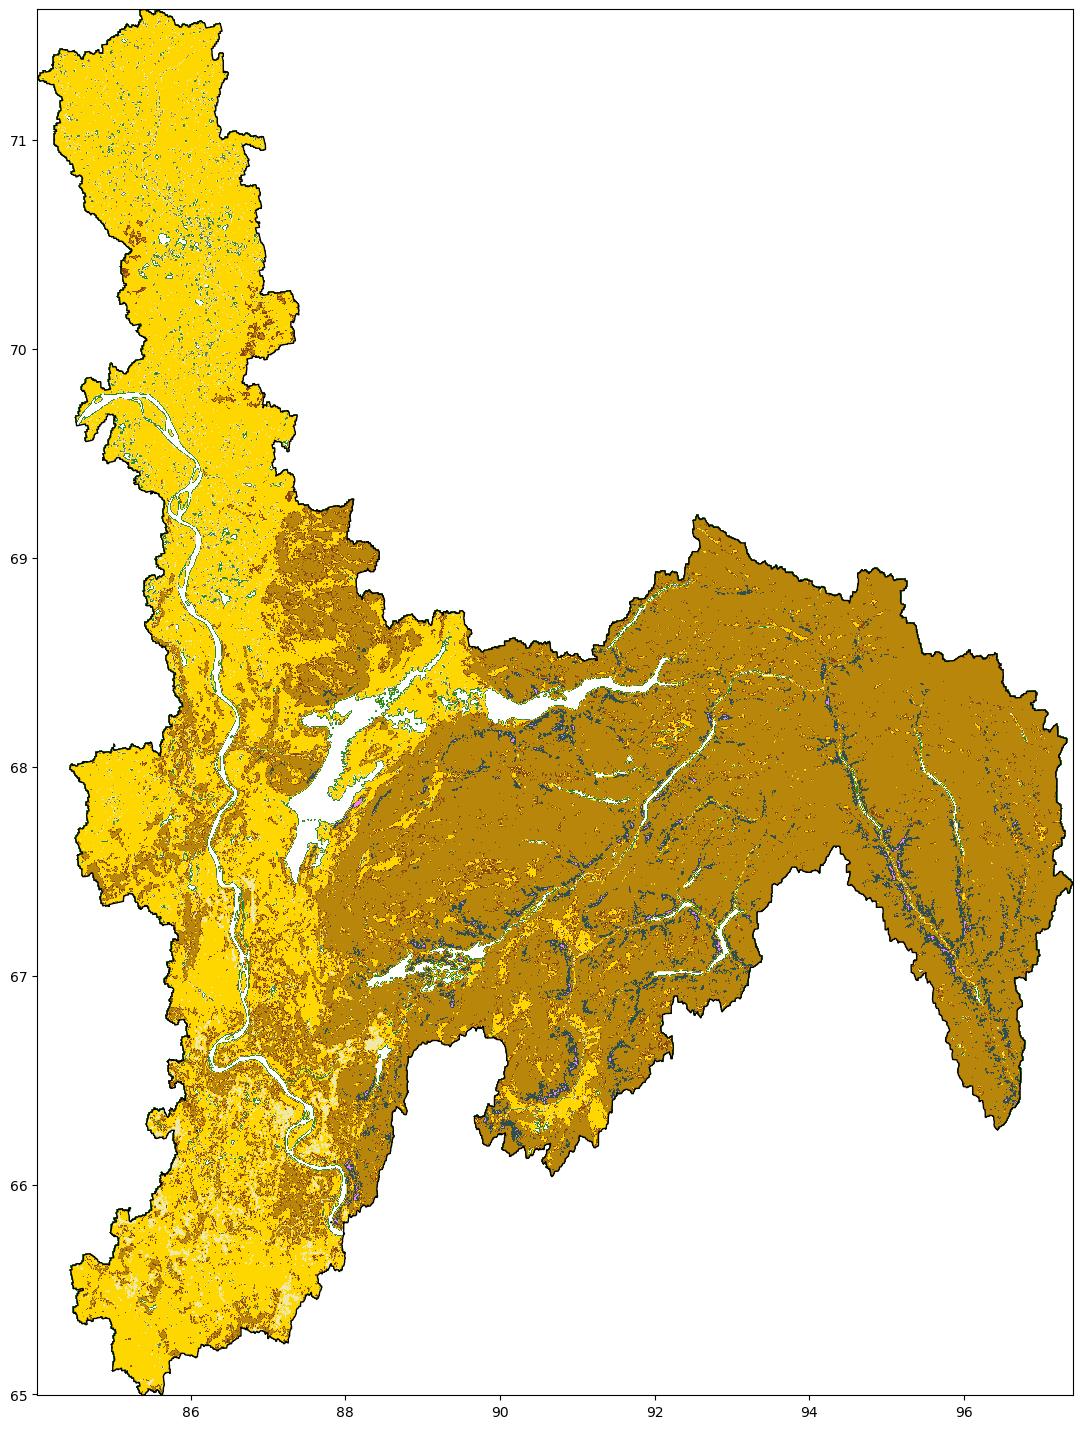

In [6]:
with rasterio.open(soil_out) as src:
    data = src.read(1)
    raster_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
# Plotting the GeoDataFrames as subplots
fig, ax = plt.subplots(figsize=(18, 18))

# Create the colormap from csv
colors = asd['order_color']
cmap = plt.matplotlib.colors.ListedColormap(colors)
norm = plt.matplotlib.colors.BoundaryNorm(asd['Value'].tolist(), cmap.N)

# Raster Data
img = ax.imshow(data, cmap=cmap, norm=norm, extent=raster_extent) 
# Vector Data
nt_confluence.plot(ax=ax, color='none', edgecolor='black', lw=1)
#ntc_lakes.plot(ax=ax, color='none', edgecolor='black', lw=1, zorder=8)

fig.savefig("Chomiak_Yenisey_Final_Maps\Chomiak_NT_Confluence_Soil.png", dpi=600, bbox_inches='tight')

In [7]:
# Reproject to EPSG:3573 for Area Calculations
soil_nt_confluence_4326 = 'Soil_nt_confluence.tif'
soil_nt_confluence_3573 = "Soil_nt_confluence_3573.tif"
reproject_raster(soil_nt_confluence_4326, 
                 soil_nt_confluence_3573, 
                 'EPSG:3573')

Raster reprojected to EPSG:3573 and saved as Soil_nt_confluence_3573.tif.


In [8]:
with rasterio.open(soil_nt_confluence_3573) as src:
    data = src.read(1)
    transform = src.transform
    pixel_size_x, pixel_size_y = src.res

# Remove nodata values and flatten the array for counting
nodata = 0
data_flat = data[data != nodata]

# Calculate unique classes and their counts
unique_classes, counts = np.unique(data_flat, return_counts=True)

# Convert counts to km^2 using raster resolution (area of 1 pixel)
pixel_area_km2 = abs(transform[0] * transform[4]) / (10**6)
area_km2_values = [count * pixel_area_km2 for count in counts]

# Create a temporary dataframe to store these values
temp_df = pd.DataFrame({'Value': unique_classes, 'Area_km2': area_km2_values})

# Merge this temporary dataframe with the 'asd' dataframe
asd = asd.merge(temp_df, on='Value', how='left')

# Calculate the percent coverage for each class
asd['Percent_coverage'] = (asd['Area_km2'] / nt_confluence_3573_area_km2) * 100
total_area_soil = asd['Area_km2'].sum()
asd['Percent_coverage_relative'] = (asd['Area_km2'] / total_area_soil) * 100

asd.head(5)

,Unnamed: 0,Value,Order,Suborder,Description,order_color,Color,color_2,Area_km2,Percent_coverage,Percent_coverage_relative
0,0,0,NaN,NaN,NaN,#ffffff,#ffffff,#ffffff,NaN,NaN,NaN
1,1,1,Alfisols,aqualfs,Albaqualfs,forestgreen,#adff2d,#669999,57.449284,0.036268,0.066127
2,2,2,Alfisols,aqualfs,Cryaqualfs,forestgreen,#adff22,#669999,51.001088,0.032197,0.058704
3,3,4,Alfisols,xeralfs,Durixeralfs,forestgreen,#a5ff2f,#669999,48.663145,0.030721,0.056013
4,4,6,Alfisols,aqualfs,Endoaqualfs,forestgreen,#87ff37,#669999,44.703726,0.028222,0.051456


In [9]:
asdasd = pd.DataFrame()
asdasd = asd
asdasd = asdasd.groupby('Order').sum()
asdasd = asdasd.dropna()

unique_orders = asd['Order'].unique()
unique_colors = asd['order_color'].unique()
unique_colors_2 = asd['color_2'].unique()
order_to_color = dict(zip(unique_orders, unique_colors_2))
asdasd['color_2'] = asdasd.index.map(order_to_color)
asdasd = asdasd.sort_values(by='Area_km2', ascending=False)
asdasd = asdasd.drop(columns=["Unnamed: 0"])

asdasd

,Value,Area_km2,Percent_coverage,Percent_coverage_relative,color_2
Order,,,,,
Inceptisols,8290,72528.788221,45.787694,83.483650,#E97451
Entisols,3963,4014.605767,2.534436,4.620978,#F7E7CE
Histosols,2832,3266.577245,2.062202,3.759966,#8A9A5B
Mollisols,11002,2362.189380,1.491259,2.718978,#635147
Ardisols,2784,1784.227331,1.126389,2.053720,#D2B48C
Alfisols,740,1289.469645,0.814047,1.484233,#669999
Spodosols,4941,1209.357400,0.763472,1.392021,#4B0082
Andisols,737,422.620843,0.266802,0.486454,#2F847C
Ultisols,7273,0.000000,0.000000,0.000000,#C08081


In [10]:
asdasd[['Area_km2','Percent_coverage']]

,Area_km2,Percent_coverage
Order,,
Inceptisols,72528.788221,45.787694
Entisols,4014.605767,2.534436
Histosols,3266.577245,2.062202
Mollisols,2362.189380,1.491259
Ardisols,1784.227331,1.126389
Alfisols,1289.469645,0.814047
Spodosols,1209.357400,0.763472
Andisols,422.620843,0.266802
Ultisols,0.000000,0.000000


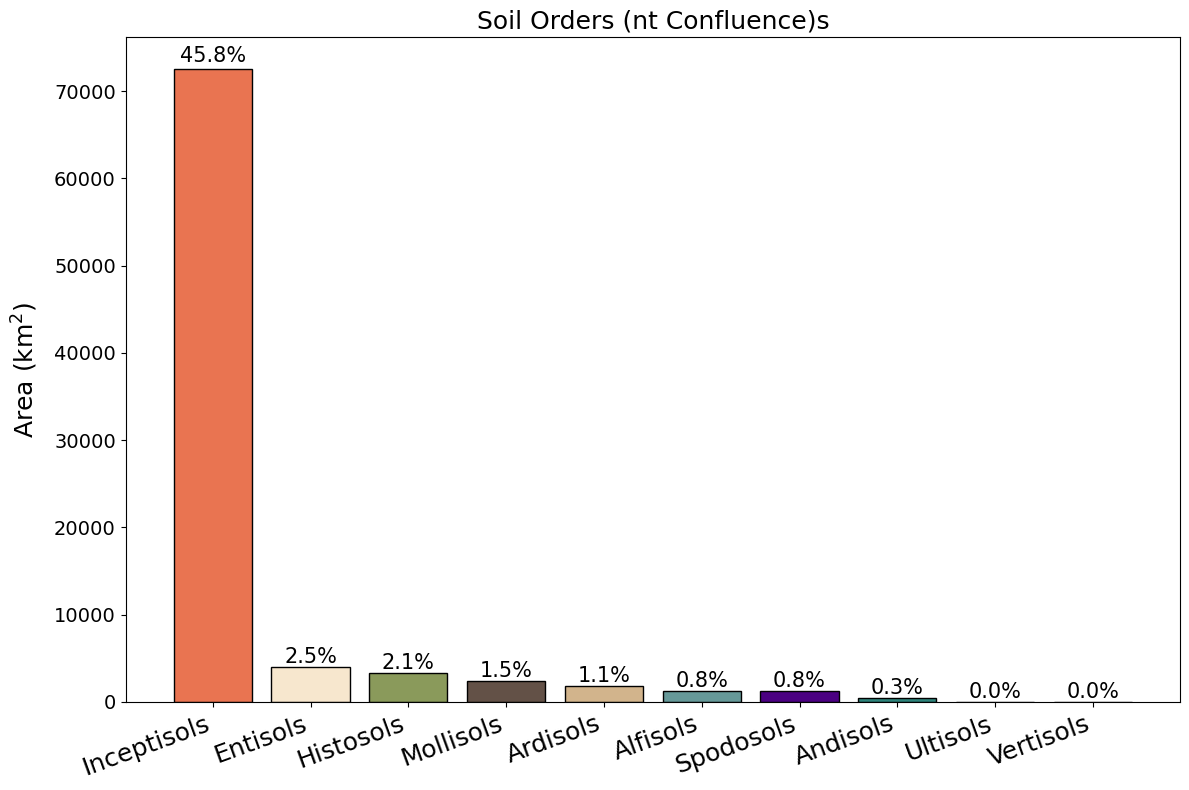

In [11]:
# Create the bar plot using the top 15 records
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(asdasd.index, asdasd['Area_km2'], color=asdasd['color_2'], edgecolor='black', align='center')

# Set title and labels
ax.set_title('Soil Orders (nt Confluence)s', fontsize=18)
ax.set_ylabel('Area (km$^2$)', fontsize=18, labelpad=10)
#ax.set_xlabel('Soil Taxonomic Classes', fontsize=14)

# Add text above each bar
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    # Multiply by 100 to convert proportion to percentage
    percentage = asdasd['Percent_coverage'].iloc[idx]
    # Format with one decimal place and add a percentage sign
    ax.text(bar.get_x() + bar.get_width()/2, 
            yval + 0.005*yval, 
            '{:.1f}%'.format(percentage), 
            ha='center', va='bottom', fontsize=15)

# Rotate x labels for better readability
plt.xticks(rotation=20, ha='right', fontsize=18)
plt.yticks(fontsize=14)
fig.tight_layout()

fig.savefig("Chomiak_Yenisey_Final_Maps\Chomiak_nt_Confluence_Soil_Barplot.png", dpi=600, bbox_inches='tight')
#fig.savefig("Yenisey_2016_USDA_Soil_Taxonomy_orders_barplot_3573.png", dpi=600, bbox_inches='tight')

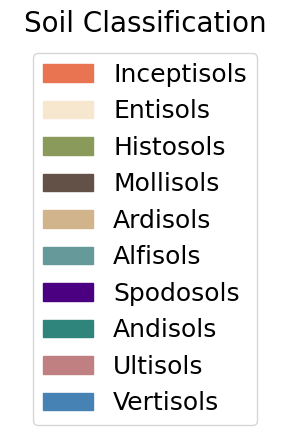

In [12]:
colors_legend = asdasd['color_2']
labels_legend = asdasd.index

# Create a list of patches
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors_legend, labels_legend)]
           
# Create the figure for the legend
fig, ax = plt.subplots(figsize=(3, 3))  # Adjust the size based on the number of columns you want
ax.legend(handles=patches, loc='upper center', fontsize=18, ncol=1)  # Adjust ncol as needed
ax.axis('off')  # Turn off the axis
plt.title("Soil Classification", fontsize=20)
plt.tight_layout()